# CSCA 5632 Unsupervised Algorithms in Machine Learning Final Project

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import RobustScaler

from itertools import permutations

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier


In [36]:
data = pd.read_csv("data/loan_default.csv")
unique_values_dict = {col: data[col].unique() for col in data.columns}

for col, unique_vals in unique_values_dict.items():
    print(f"Unique values in {col}: {unique_vals}")

nan_percentage = data.isna().mean() * 100


print(nan_percentage)
unnecessary_features = ['ID','year']
display(data.head())

Unique values in ID: [ 24890  24891  24892 ... 173557 173558 173559]
Unique values in year: [2019]
Unique values in loan_limit: ['cf' nan 'ncf']
Unique values in Gender: ['Sex Not Available' 'Male' 'Joint' 'Female']
Unique values in approv_in_adv: ['nopre' 'pre' nan]
Unique values in loan_type: ['type1' 'type2' 'type3']
Unique values in loan_purpose: ['p1' 'p4' 'p3' 'p2' nan]
Unique values in Credit_Worthiness: ['l1' 'l2']
Unique values in open_credit: ['nopc' 'opc']
Unique values in business_or_commercial: ['nob/c' 'b/c']
Unique values in loan_amount: [ 116500  206500  406500  456500  696500  706500  346500  266500  376500
  436500  136500  466500  226500   76500  356500  156500  586500  306500
  316500  336500  426500  476500  196500  186500  246500  216500  506500
  656500  256500  396500  166500  236500  866500  416500  386500  596500
  606500   86500  286500  146500  446500  636500  486500  326500   56500
  906500  496500  106500  126500  296500  176500 1376500  566500  686500
  5

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [38]:
data.drop_duplicates(inplace=True)
data.drop(columns=unnecessary_features, inplace=True)
data = data.dropna(how='all')

# set a column's datatype as categorical or numeric
categorical_columns = ['loan_limit', 'Gender', 'approv_in_adv', 
                       'loan_type', 'loan_purpose','Credit_Worthiness', 'open_credit',
                       'business_or_commercial','term','Neg_ammortization','interest_only',
                       'lump_sum_payment','Neg_ammortization','construction_type',
                       'occupancy_type','Secured_by','total_units','credit_type',
                       'co-applicant_credit_type','age','submission_of_application','Region',
                       'Security_Type'
                       ]
numerical_columns = ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

In [39]:
# missing values with mode
for column in categorical_columns:
    if column in data.columns:
        data[column] = data[column].fillna(data[column].mode()[0])

# missing values with median
for column in numerical_columns:
    if column in data.columns:
        data[column] = data[column].fillna(data[column].median())

# Replace outliers with median
for column in numerical_columns:
    if column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median = data[column].median()
        data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), median, data[column])

    
# Use one-hot encoding to convert categorical variables into numerical format.
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Encode the target variable 'Status' as numeric.
data['Status'] = data['Status'].astype(int)


# Normalize/scale numerical features
scaler = RobustScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data['Status'] = data['Status'].astype('category').cat.codes

In [42]:
missing_values = data.isnull().sum()
print(missing_values)
missing_columns = data.isnull().any()
print(missing_columns)
has_nan = data.isnull().values.any()
print(f'Does the DataFrame have any NaN values? {has_nan}')
data.info()


loan_amount                          0
rate_of_interest                     0
Interest_rate_spread                 0
Upfront_charges                      0
property_value                       0
                                    ..
submission_of_application_to_inst    0
Region_North-East                    0
Region_central                       0
Region_south                         0
Security_Type_direct                 0
Length: 74, dtype: int64
loan_amount                          False
rate_of_interest                     False
Interest_rate_spread                 False
Upfront_charges                      False
property_value                       False
                                     ...  
submission_of_application_to_inst    False
Region_North-East                    False
Region_central                       False
Region_south                         False
Security_Type_direct                 False
Length: 74, dtype: bool
Does the DataFrame have any NaN values? False
<cl

In [45]:
# Filter the dataframe to include only numeric columns
# numeric_data = data.select_dtypes(include=['int64', 'float64']).drop(columns=['Status'])
numeric_data = data.select_dtypes(include=['number']).drop(columns=['Status'])



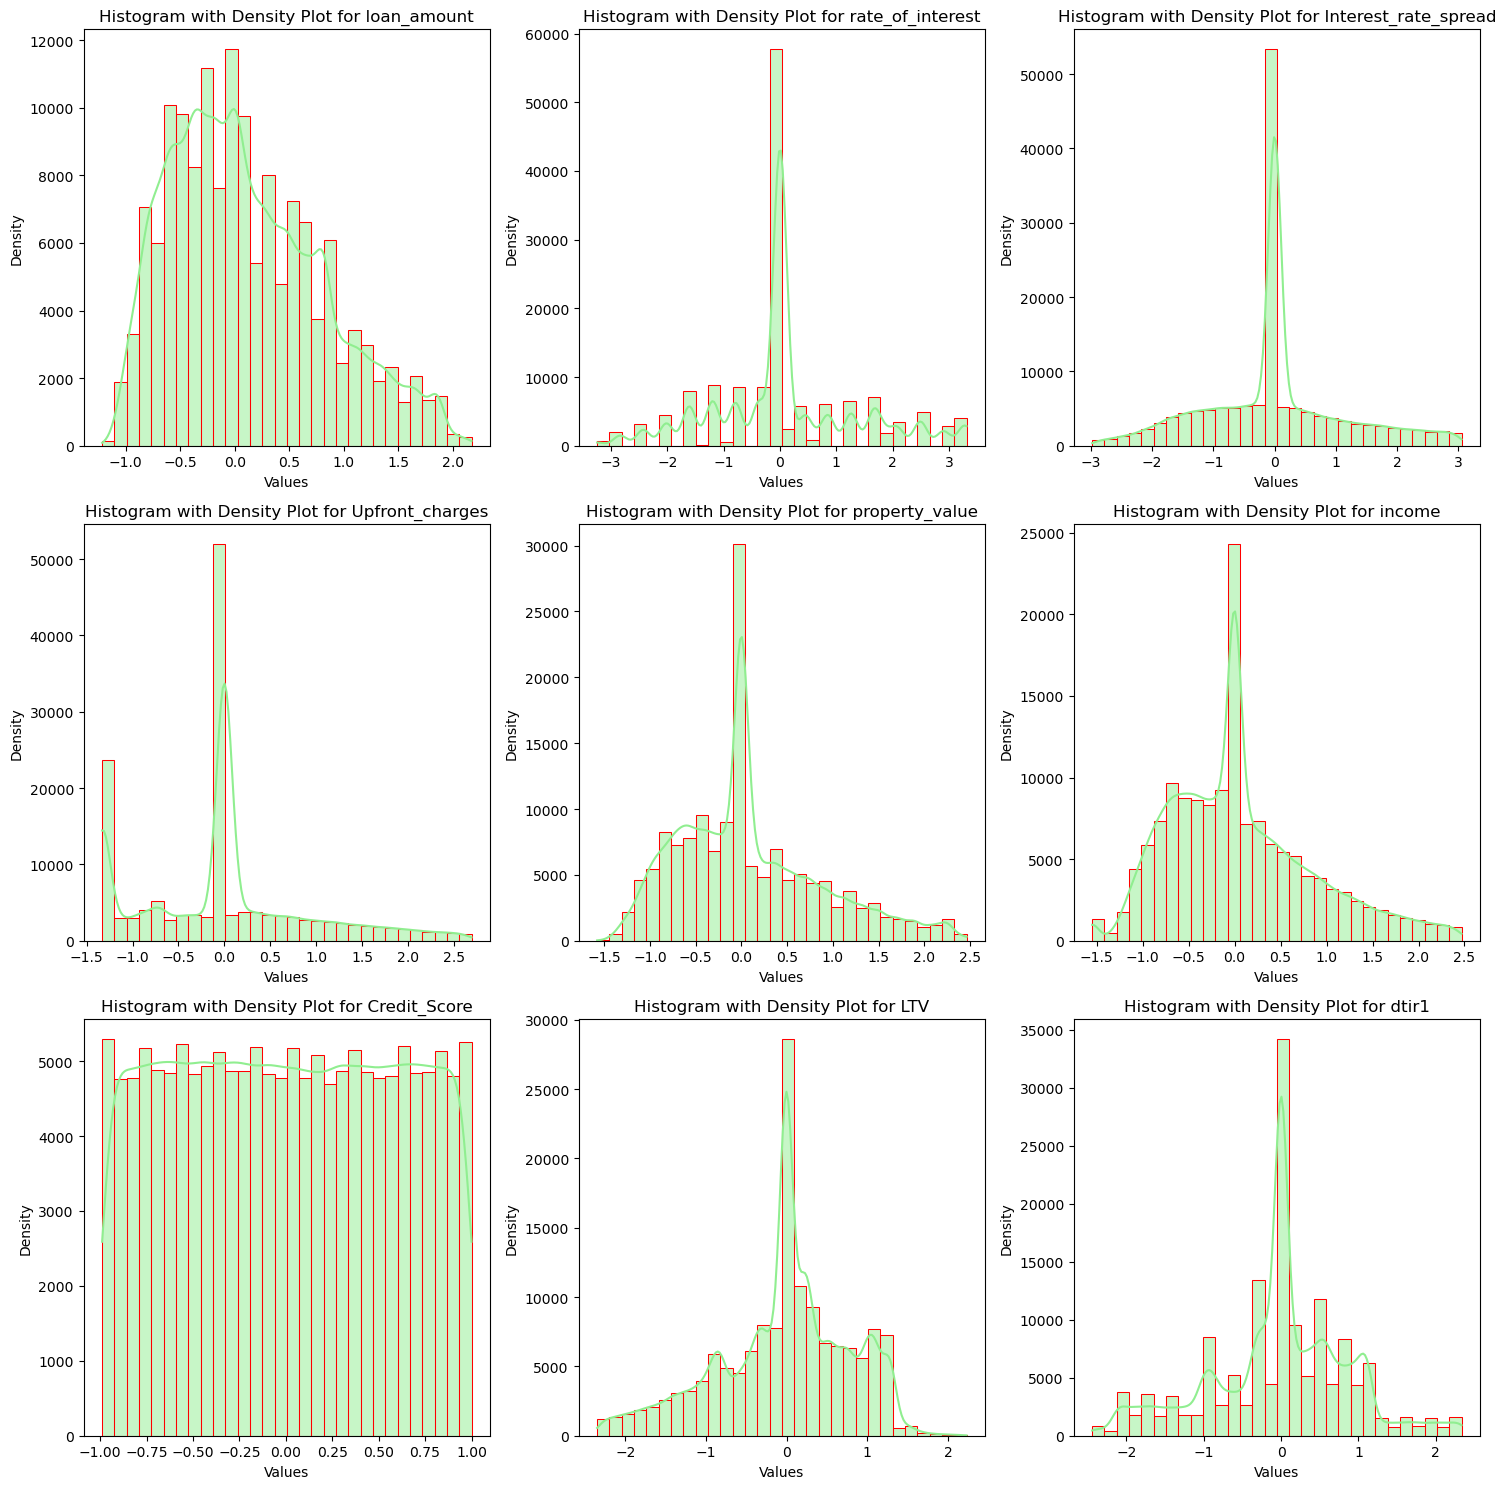

In [47]:
# Plot histograms for each numeric feature in one chart
num_features = numeric_data.shape[1]
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

plt.figure(figsize=(15, num_rows * 5))

for i, feature in enumerate(numeric_data.columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(numeric_data[feature], bins=30, kde=True, color='lightgreen', edgecolor='red')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.title(f'Histogram with Density Plot for {feature}')

plt.tight_layout()
plt.show()

Status                               1.000000
credit_type_EQUI                     0.592168
co-applicant_credit_type_EXP         0.144239
submission_of_application_to_inst    0.122410
term_300.0                           0.103004
dtir1                                0.101357
loan_type_type2                      0.092550
LTV                                  0.077792
Gender_Sex Not Available             0.053336
loan_limit_ncf                       0.053332
Region_south                         0.040051
Credit_Worthiness_l2                 0.034875
loan_purpose_p2                      0.029369
age_>74                              0.028021
Secured_by_land                      0.026055
total_units_2U                       0.022978
Gender_Male                          0.022653
age_65-74                            0.020665
Region_central                       0.016738
total_units_3U                       0.016460
age_55-64                            0.015257
Region_North-East                 

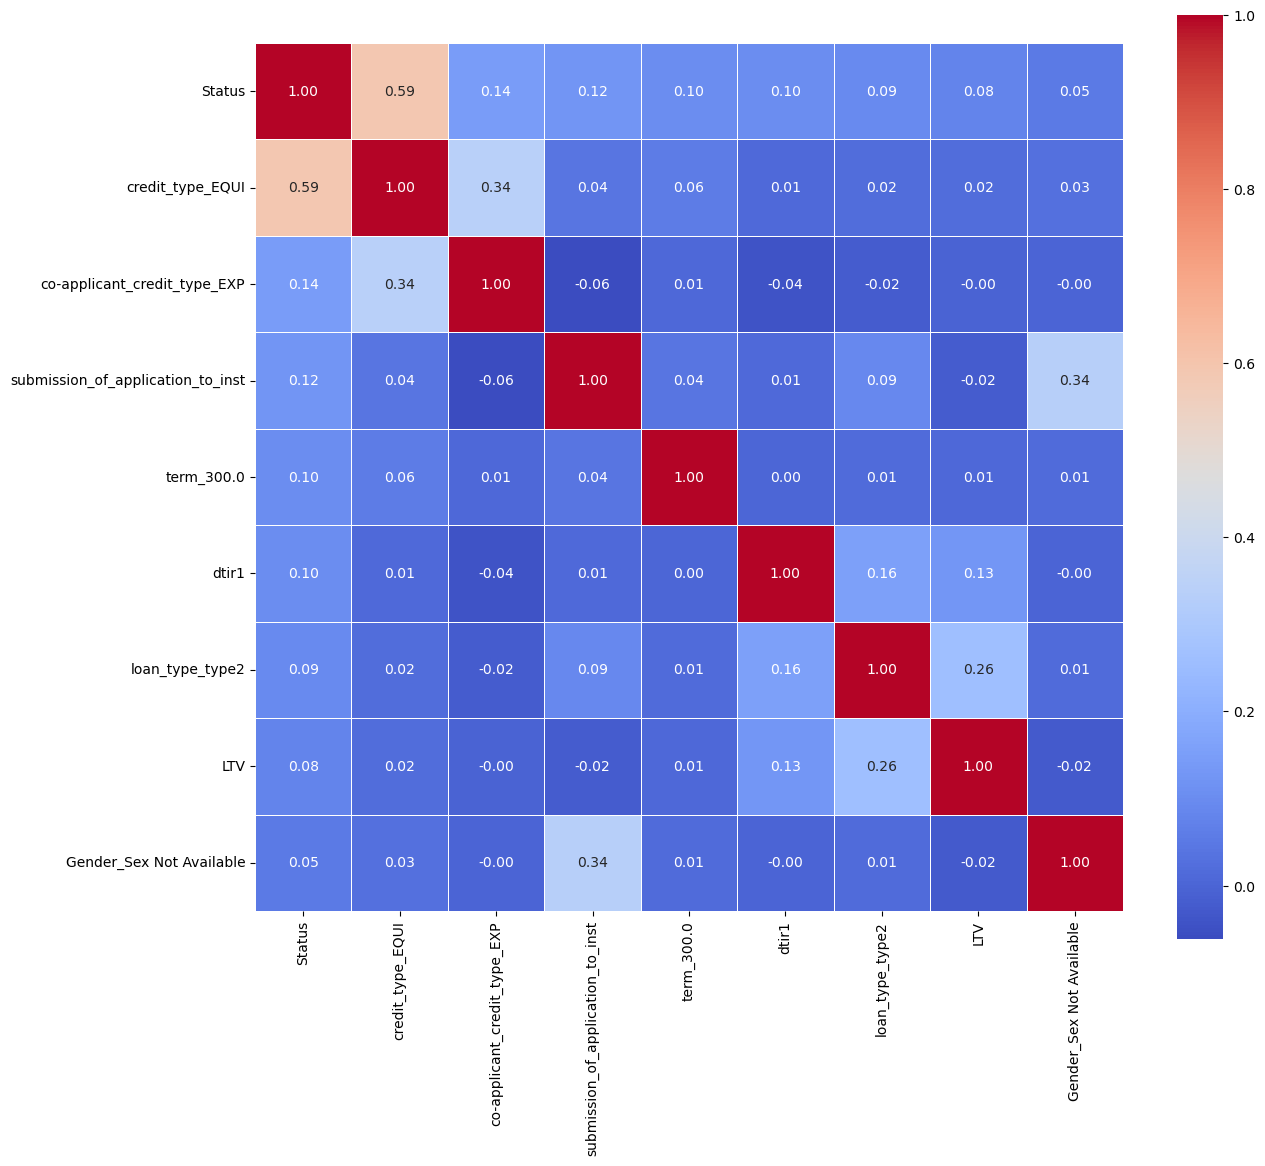

In [49]:
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix["Status"].sort_values(ascending=False)
top_corr_features = correlation_with_target.index[1:9]  # Select top 8 correlated features
top_corr_features = top_corr_features.insert(0, "Status")
filtered_corr_matrix = correlation_matrix.loc[top_corr_features, top_corr_features]

print(correlation_with_target.to_string())

plt.figure(figsize=(14, 12))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.show()